# Traning a CNN model to detect PPE

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.0/715.0 kB 10.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2


In [4]:
warnings.filterwarnings("ignore")

np.random.seed(12345)

%matplotlib inline

!wandb disabled

/bin/bash: line 1: wandb: command not found


In [5]:
Input_path = '/content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data'
# Work_path = '/content/drive/MyDrive/colab/working_dir/'
Work_path = '/content/drive/MyDrive/colab/data/ppe_data_kaggle/work_path'

In [6]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [7]:
dict_file = {'train': os.path.join(Input_path, 'train'),
             'val': os.path.join(Input_path, 'valid'),
             'test': os.path.join(Input_path, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(Work_path, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [8]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(Input_path, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

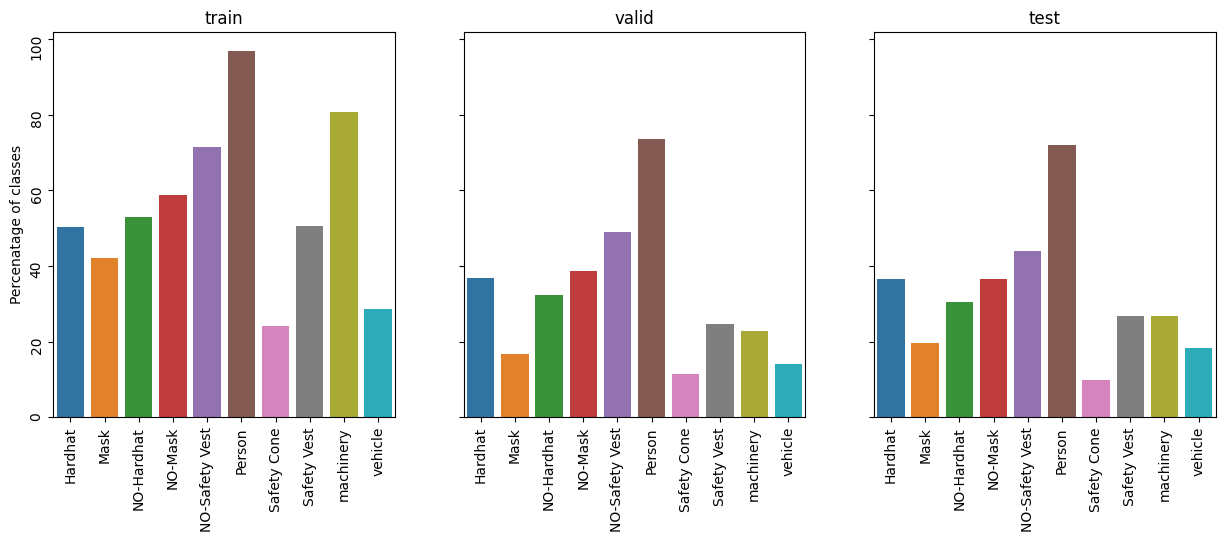

In [9]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

In [10]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(Input_path, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


In [11]:
for mode in ['train', 'valid', 'test']:

    files =  glob.glob(os.path.join(Input_path, mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82



In [12]:
# model = YOLO('yolov8l.pt')
model = YOLO('/content/drive/MyDrive/colab/data/ppe_data_kaggle/runs/detect/yolov8l_v1/trained_model/weights/best.pt')


In [13]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 15 15:23:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              45W / 350W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [14]:
model.train(data=os.path.join(Work_path,'data.yaml'),
            task='detect',
            imgsz=640,
            epochs=100,
            batch=32,
            mode='train',
            name='yolov8l_v1_train_epoch_130')

Ultralytics YOLOv8.1.14 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/colab/data/ppe_data_kaggle/runs/detect/yolov8l_v1/trained_model/weights/best.pt, data=/content/drive/MyDrive/colab/data/ppe_data_kaggle/work_path/data.yaml, epochs=100, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8l_v1_train_epoch_130, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fals

100%|██████████| 755k/755k [00:00<00:00, 38.2MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

100%|██████████| 6.23M/6.23M [00:00<00:00, 152MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/train/labels.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8l_v1_train_epoch_130/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8l_v1_train_epoch_130
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      19.8G     0.6988     0.5473      1.066        331        640: 100%|██████████| 82/82 [00:51<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        114        697      0.883      0.774      0.833      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100        20G     0.7741     0.6197      1.098        289        640: 100%|██████████| 82/82 [00:26<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all        114        697      0.879      0.695      0.784      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      20.4G      0.814     0.6781      1.136        266        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all        114        697       0.87      0.708      0.771      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      19.6G     0.8549       0.73      1.165        256        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all        114        697      0.855      0.711      0.784      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100        21G     0.8655     0.7453      1.172        248        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all        114        697      0.813      0.614       0.69      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      20.2G     0.8659     0.7378      1.171        264        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all        114        697      0.856      0.717      0.776      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      20.3G     0.8659     0.7297       1.17        306        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all        114        697      0.869      0.676      0.757      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      20.2G     0.8524     0.7133      1.155        211        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all        114        697      0.837      0.675      0.749      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      19.9G     0.8324     0.6993      1.145        293        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all        114        697      0.869      0.714      0.782      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      20.3G     0.8275     0.6723      1.142        303        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all        114        697      0.831      0.726      0.784      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      20.2G     0.8143     0.6705      1.139        215        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all        114        697      0.877      0.718      0.784      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      20.6G     0.8055     0.6426      1.122        316        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all        114        697      0.852      0.729      0.785      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      20.7G     0.7928     0.6316      1.119        282        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all        114        697      0.827      0.735       0.79      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      20.1G     0.7847     0.6179      1.105        250        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all        114        697      0.867      0.732      0.795      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      21.3G     0.7707     0.6211      1.112        291        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all        114        697      0.856      0.728      0.801       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      19.6G     0.7794     0.6125      1.111        314        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all        114        697      0.886      0.747      0.816      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100        20G     0.7581     0.5865      1.091        262        640: 100%|██████████| 82/82 [00:25<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all        114        697      0.886      0.734      0.795      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      20.7G     0.7566     0.5922      1.092        258        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all        114        697      0.897       0.72       0.81       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      20.6G     0.7416     0.5772       1.09        239        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all        114        697      0.935       0.72       0.81      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      19.9G     0.7335     0.5685      1.078        294        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all        114        697      0.894      0.767      0.826      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      20.6G       0.73     0.5615      1.072        228        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all        114        697      0.878      0.772      0.821      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      19.9G     0.7385      0.574      1.084        244        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all        114        697      0.896      0.771      0.838      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      20.1G     0.7322     0.5607       1.08        233        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all        114        697      0.893      0.763      0.832      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      20.1G     0.7186     0.5396      1.062        273        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all        114        697      0.912      0.746      0.822      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      20.1G     0.7146     0.5467      1.066        415        640: 100%|██████████| 82/82 [00:25<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all        114        697      0.903      0.757      0.833      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      20.1G     0.7136     0.5407      1.065        190        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all        114        697      0.865      0.802      0.843      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      20.4G     0.7149     0.5424      1.064        269        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all        114        697      0.937      0.768      0.852      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      20.1G     0.6952     0.5226      1.055        226        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all        114        697      0.942       0.76      0.843      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      20.1G     0.6973     0.5259      1.063        283        640: 100%|██████████| 82/82 [00:25<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all        114        697      0.919      0.756      0.835      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      20.3G     0.6884     0.5225      1.054        324        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all        114        697      0.922      0.771      0.845      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      19.8G      0.679       0.51      1.043        264        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all        114        697      0.908      0.792      0.852      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      20.6G      0.672     0.4971      1.042        333        640: 100%|██████████| 82/82 [00:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all        114        697      0.908      0.779      0.852      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      20.1G     0.6724     0.5009      1.042        259        640: 100%|██████████| 82/82 [00:25<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all        114        697      0.946      0.778      0.856      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      20.3G     0.6655     0.4997      1.034        199        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all        114        697      0.914      0.791      0.851      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100        20G     0.6625     0.4875      1.033        210        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all        114        697       0.92      0.782      0.854      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      19.8G     0.6627     0.4894      1.032        231        640: 100%|██████████| 82/82 [00:25<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all        114        697      0.927      0.789      0.852      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      19.3G     0.6406     0.4723      1.028        275        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all        114        697       0.91      0.795      0.858      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      20.1G     0.6378     0.4767      1.026        254        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all        114        697      0.934      0.771      0.846      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      20.3G     0.6388     0.4688      1.022        233        640: 100%|██████████| 82/82 [00:25<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all        114        697      0.893      0.806      0.862      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      19.8G     0.6485     0.4768      1.022        263        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all        114        697      0.906      0.814      0.868       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      20.6G     0.6403     0.4659      1.016        360        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all        114        697      0.911      0.803      0.865      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      20.3G     0.6328     0.4632      1.015        337        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all        114        697      0.909      0.816      0.875      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      20.3G      0.622     0.4483      1.013        307        640: 100%|██████████| 82/82 [00:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all        114        697      0.914      0.812      0.859      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      20.2G     0.6143     0.4499      1.006        358        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all        114        697      0.951      0.795      0.863      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      20.3G     0.6133     0.4485      1.009        251        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all        114        697       0.92      0.801      0.867      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100        20G     0.6063     0.4394     0.9992        202        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all        114        697      0.912      0.795      0.854      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100        20G     0.6054     0.4382      1.001        272        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all        114        697      0.912      0.788      0.866      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      19.9G     0.6013     0.4352     0.9987        249        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all        114        697      0.896      0.819      0.868      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      20.6G     0.5907     0.4332     0.9975        278        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all        114        697      0.926      0.811       0.87      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      20.1G     0.5974     0.4315     0.9966        263        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all        114        697      0.913      0.816      0.865      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      20.4G     0.5885     0.4241     0.9952        336        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all        114        697      0.934      0.824      0.877      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      19.8G     0.5847      0.417     0.9872        333        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all        114        697       0.94      0.807      0.868       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      19.9G     0.5732     0.4147     0.9823        283        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all        114        697      0.929      0.811      0.869      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      19.4G     0.5812     0.4098      0.981        358        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all        114        697      0.911       0.84      0.878      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100        21G     0.5743     0.4109     0.9788        246        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all        114        697      0.906      0.818      0.874      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      20.3G     0.5638     0.4045     0.9791        345        640: 100%|██████████| 82/82 [00:25<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all        114        697      0.905      0.832      0.879      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      20.5G     0.5632     0.4014     0.9782        173        640: 100%|██████████| 82/82 [00:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all        114        697       0.94      0.798      0.869       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      20.1G     0.5597      0.402      0.976        233        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all        114        697      0.916      0.819      0.873      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      19.9G     0.5543     0.3942      0.973        305        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all        114        697      0.924      0.832      0.885      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      20.4G     0.5538     0.3948     0.9728        287        640: 100%|██████████| 82/82 [00:27<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all        114        697      0.941      0.822      0.887      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      20.1G     0.5482     0.3907     0.9724        338        640: 100%|██████████| 82/82 [00:25<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all        114        697      0.926      0.845      0.889      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100        20G     0.5411     0.3899     0.9729        276        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all        114        697      0.939      0.818      0.881      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100        21G     0.5377     0.3866     0.9644        219        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all        114        697      0.943      0.809      0.885      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      20.4G     0.5296     0.3761     0.9611        304        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all        114        697      0.925      0.806      0.881      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      20.8G     0.5353     0.3783     0.9605        283        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all        114        697       0.94      0.817      0.882      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      20.8G     0.5304     0.3782     0.9565        226        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all        114        697      0.927      0.827      0.876      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      20.9G     0.5185     0.3621     0.9558        206        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all        114        697      0.945      0.822       0.88      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      20.6G     0.5175     0.3666     0.9547        351        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all        114        697      0.938      0.821      0.889      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      20.1G     0.5145     0.3619     0.9534        267        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all        114        697      0.931      0.824      0.882      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      20.3G     0.5103     0.3556      0.952        245        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all        114        697      0.956      0.817      0.884      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      20.3G     0.5131     0.3594     0.9504        403        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all        114        697      0.941      0.816      0.887      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      20.2G     0.5083     0.3564     0.9464        313        640: 100%|██████████| 82/82 [00:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all        114        697      0.949      0.827      0.892      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      20.1G     0.4988     0.3528     0.9463        275        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all        114        697       0.96      0.815      0.888      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      20.4G     0.4986      0.353     0.9461        242        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all        114        697      0.946      0.815      0.886      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      20.9G     0.4936     0.3484     0.9427        234        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all        114        697      0.952      0.827      0.892      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      20.5G     0.4904     0.3478     0.9419        380        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all        114        697      0.953      0.828      0.895      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      20.3G     0.4908     0.3401     0.9405        228        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all        114        697      0.959      0.835      0.894      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      20.1G     0.4865     0.3378     0.9365        171        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all        114        697      0.968      0.826      0.894      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      20.2G     0.4832     0.3393     0.9343        261        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all        114        697      0.941      0.842      0.896      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      20.3G     0.4846     0.3386     0.9335        416        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all        114        697      0.944      0.826      0.898      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      20.3G     0.4741      0.331     0.9312        459        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all        114        697      0.937      0.834      0.898      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      20.2G     0.4751     0.3331     0.9295        265        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all        114        697      0.937      0.834      0.893       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      20.3G     0.4634      0.324     0.9255        276        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all        114        697      0.956       0.82      0.895      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      20.6G     0.4676      0.323     0.9279        350        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all        114        697      0.928      0.826      0.893      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      20.3G      0.461     0.3249     0.9256        271        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all        114        697      0.946      0.826      0.894      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      20.3G      0.458     0.3194     0.9246        311        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all        114        697      0.948      0.825      0.894      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      20.3G     0.4517     0.3149     0.9229        255        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all        114        697      0.919      0.842      0.895      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      20.3G     0.4527     0.3167     0.9217        293        640: 100%|██████████| 82/82 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all        114        697      0.946      0.832      0.899      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      20.3G     0.4428     0.3114     0.9182        211        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all        114        697      0.951       0.83      0.897      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      19.9G     0.4465     0.3114     0.9191        358        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all        114        697      0.941      0.828      0.897      0.671


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      20.6G     0.4438     0.2619     0.9044        121        640: 100%|██████████| 82/82 [00:31<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all        114        697      0.954       0.82      0.893      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      20.5G     0.4248     0.2497     0.8946        176        640: 100%|██████████| 82/82 [00:25<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all        114        697      0.937      0.834      0.895      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      20.7G     0.4182      0.247     0.8937        219        640: 100%|██████████| 82/82 [00:25<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all        114        697       0.95      0.823      0.895      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      20.5G     0.4124     0.2447     0.8919        148        640: 100%|██████████| 82/82 [00:25<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all        114        697      0.939       0.83      0.898      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      20.6G     0.4102     0.2414     0.8853        208        640: 100%|██████████| 82/82 [00:25<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all        114        697      0.913      0.848      0.894      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      20.3G     0.4018     0.2397     0.8839        190        640: 100%|██████████| 82/82 [00:24<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all        114        697      0.954      0.817      0.895       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      20.7G      0.396     0.2363     0.8818        165        640: 100%|██████████| 82/82 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all        114        697       0.94      0.826      0.896       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      20.6G     0.3969     0.2362     0.8835        175        640: 100%|██████████| 82/82 [00:25<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all        114        697      0.934      0.831      0.898      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      20.6G     0.3952     0.2369     0.8832        132        640: 100%|██████████| 82/82 [00:25<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all        114        697      0.922      0.838      0.898      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      20.3G     0.3885     0.2308      0.879        144        640: 100%|██████████| 82/82 [00:25<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all        114        697      0.937      0.825      0.898      0.672



100 epochs completed in 0.793 hours.
Optimizer stripped from runs/detect/yolov8l_v1_train_epoch_130/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/yolov8l_v1_train_epoch_130/weights/best.pt, 87.7MB

Validating runs/detect/yolov8l_v1_train_epoch_130/weights/best.pt...
Ultralytics YOLOv8.1.14 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 43614318 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


                   all        114        697      0.923      0.837      0.898      0.673
               Hardhat        114         79          1      0.869      0.951      0.694
                  Mask        114         21      0.969      0.952      0.964      0.799
            NO-Hardhat        114         69      0.913      0.757      0.885       0.55
               NO-Mask        114         74      0.918       0.73      0.785      0.552
        NO-Safety Vest        114        106      0.944      0.821      0.886      0.642
                Person        114        166      0.973      0.855      0.926      0.702
           Safety Cone        114         44      0.902      0.886      0.936       0.64
           Safety Vest        114         41      0.936      0.878      0.943      0.777
             machinery        114         55      0.911      0.945      0.959      0.806
               vehicle        114         42       0.76      0.679      0.744       0.57
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c75d2350880>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [15]:
results = model.predict(source=os.path.join(Input_path, 'test', 'images'), save=True)


image 1/82 /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 14.0ms
image 2/82 /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 2 NO-Masks, 1 NO-Safety Vest, 3 Persons, 14.1ms
image 3/82 /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 3 NO-Masks, 3 NO-Safety Vests, 2 Persons, 14.6ms
image 4/82 /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 1 Safety Cone, 1 vehicle, 14.2ms
image 5/82 /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 1 NO-Hardhat

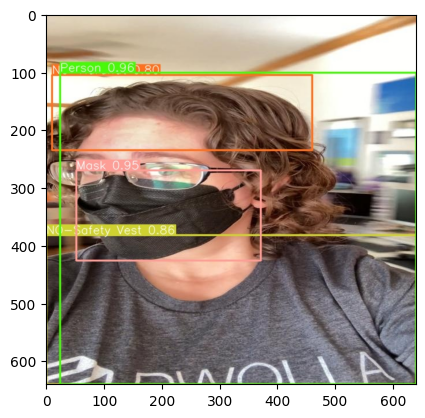

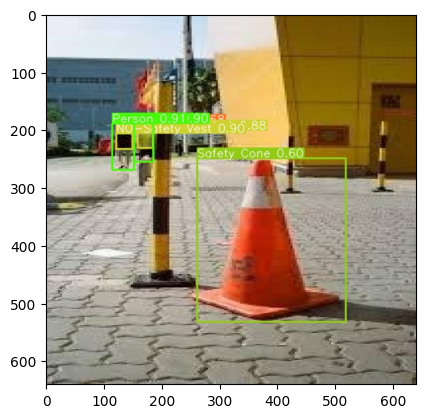

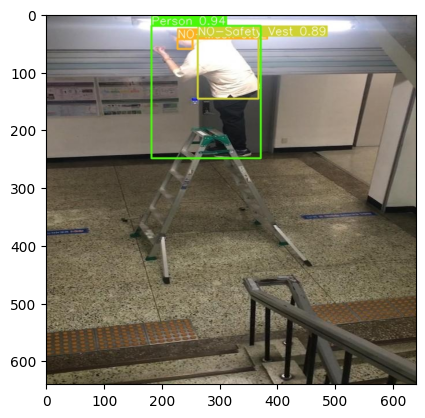

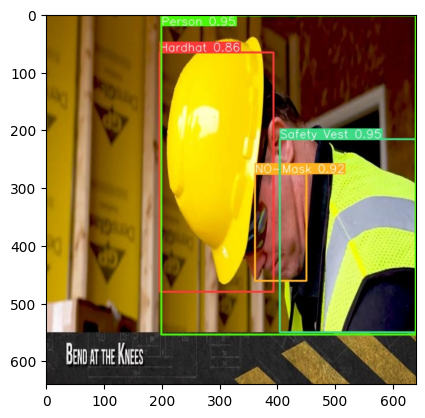

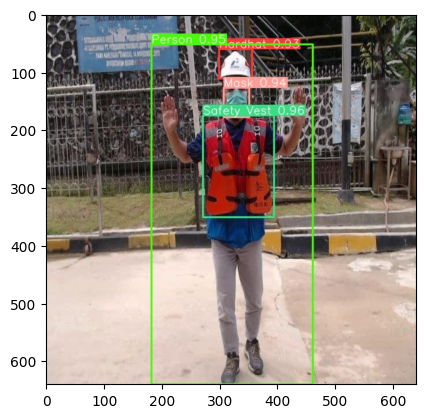

In [17]:
%matplotlib inline

predicitions = glob.glob(os.path.join(Work_path, '/content/drive/MyDrive/colab/data/ppe_data_kaggle/runs/detect/yolov8l_v1_130e/predict', '*'))
n = 5

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()


How to use prediction model:

1.   Save folder in your google drive
2.   Mount google drive
3.   Load Model below



In [3]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.0/715.0 kB 6.5 MB/s eta 0:00:00


In [4]:
# Step 1 - Mount google drive
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Step 2 - load packages
import os
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2
warnings.filterwarnings("ignore")


NameError: name 'warnings' is not defined

In [19]:
# Step 3 - Load model (modify the path as per where you've store the path)
model_nano_30e   = YOLO('/content/drive/MyDrive/colab/data/ppe_data_kaggle/runs/detect/yolov8n_v1_30e/trained_model/weights/best.pt')
model_large_30e  = YOLO('/content/drive/MyDrive/colab/data/ppe_data_kaggle/runs/detect/yolov8l_v1_30e/trained_model/weights/best.pt')
model_large_130e = YOLO('/content/drive/MyDrive/colab/data/ppe_data_kaggle/runs/detect/yolov8l_v1_130e/trained_model/weights/best.pt')

In [6]:
Input_path = '/content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data'

In [22]:
results_nano_30e = model_nano_30e.predict(source=os.path.join(Input_path, 'gt', 'images'), save=True)
results_large_30e = model_large_30e.predict(source=os.path.join(Input_path, 'gt', 'images'), save=True)
results_large_130e = model_large_130e.predict(source=os.path.join(Input_path, 'gt', 'images'), save=True)



image 1/1 /content/drive/MyDrive/colab/data/ppe_data_kaggle/css-data/gt/images/PXL_20240213_115152049.PORTRAIT.jpg: 640x480 1 NO-Hardhat, 1 NO-Mask, 2 Persons, 1 Safety Vest, 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict3


In [ ]:
predicitions = glob.glob(os.path.join(Work_path, '/content/drive/MyDrive/colab/data/ppe_data_kaggle/gt_image_predict', '*'))
n = 1

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

In [ ]:
!zip -r /content/runs.zip /content/runs

In [ ]:
from google.colab import files
files.download("/content/runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>